### Import Original Data

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

datafile = "no_na_terms.csv"
no_na_terms = pd.read_csv(datafile)

In [259]:
no_na_terms.head()

,Unnamed: 0,Year,Month,State,Primary Mode,Illnesses,Outbreak ID,Strain,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],HDI (1995),Average High (F),Average Low (F),Length of Genome,%GC,Protein Coding Genes,Genes Overall,tRNA Genes
0,0,2009,1,Massachusetts,Food,3,2009 1 Massachusetts,O157:H7,871,7800,0.96,0.905,39,25,5.59,50.45,5155,5417,103
1,1,2010,7,Massachusetts,Other,2,2010 7 Massachusetts,O157:H7,871,7800,0.96,0.905,80,65,5.59,50.45,5155,5417,103
2,2,2011,7,Massachusetts,Other,8,2011 7 Massachusetts,O157:H7,871,7800,0.96,0.905,80,65,5.59,50.45,5155,5417,103
3,3,2012,4,Massachusetts,Food,2,2012 4 Massachusetts,O157:H7,871,7800,0.96,0.905,66,50,5.59,50.45,5155,5417,103
4,4,2012,5,Massachusetts,Food,6,2012 5 Massachusetts,O157:H7,871,7800,0.96,0.905,76,60,5.59,50.45,5155,5417,103


### Bring in data from StateMaster.com for total restaurants per state

In [260]:
from urllib.request import Request, urlopen

req = Request('http://www.statemaster.com/graph/lif_res-lifestyle-resturants', headers={'User-Agent': 'Mozilla/5.0'})
url = urlopen(req).read()

In [261]:
restaurants_raw = pd.read_html(url, header=0)[0]

In [262]:
restaurants_raw = restaurants_raw.loc[:,['States', 'Amount']]
restaurants_trim = restaurants_raw.iloc[51:103, :]
restaurants_trim['States'] = restaurants_trim['States'].map(lambda x: str(x)[:-1])

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [263]:
restaurants_trim = restaurants_trim[restaurants_trim.States != 'District of Columbia']

In [264]:
restaurants_trim = restaurants_trim.dropna().reset_index().drop('index', axis=1)

In [265]:
restaurants_trim['Amount'] = restaurants_trim['Amount'].astype(int)

### Bring in data from StateMaster.com for % Adults who have consumed fruits and vegetables five or more times per day

In [266]:
from urllib.request import Request, urlopen

req = Request('http://www.statemaster.com/graph/hea_fru_and_veg_con-health-fruits-and-vegetables-consumption', headers={'User-Agent': 'Mozilla/5.0'})
url = urlopen(req).read()

In [267]:
fruit_veg_raw = pd.read_html(url, header=0)[0]

In [268]:
fruit_veg_raw = fruit_veg_raw.loc[:,['States', 'Amount']]
fruit_veg_trim = fruit_veg_raw.iloc[51:105, :]
fruit_veg_trim['States'] = fruit_veg_trim['States'].map(lambda x: str(x)[:-1])
fruit_veg_trim['Amount'] = fruit_veg_trim['Amount'].map(lambda x: str(x)[:-1])

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [269]:
fruit_veg_trim = fruit_veg_trim[fruit_veg_trim.States != 'District of Columbia']
fruit_veg_trim = fruit_veg_trim[fruit_veg_trim.States != 'US Virgin Islands']
fruit_veg_trim = fruit_veg_trim[fruit_veg_trim.States != 'Puerto Rico']
fruit_veg_trim = fruit_veg_trim[fruit_veg_trim.States != 'Guam']

In [270]:
fruit_veg_trim = fruit_veg_trim[fruit_veg_trim.States != 'na'].reset_index().drop('index', axis=1)

In [271]:
fruit_veg_trim['Amount'] = fruit_veg_trim['Amount'].astype(float)

### Merge new features to original data, drop previous features except for region and strain

In [272]:
plus_res = no_na_terms.copy()
plus_res = plus_res[['State','Strain','Illnesses','Average Low (F)','Landarea(mi2)']]

In [273]:
plus_res = pd.merge(plus_res, restaurants_trim, right_on='States', left_on='State')
plus_res['Amount Restaurants'] = plus_res['Amount']
plus_res = plus_res.drop('Amount', axis=1)
plus_res_fruit_veg = pd.merge(plus_res, fruit_veg_trim, right_on='States', left_on='State')
plus_res_fruit_veg['%Fruit Veg'] = plus_res_fruit_veg['Amount']

In [274]:
plus_res_fruit_veg = plus_res_fruit_veg[['State', 'Strain', 'Amount Restaurants', '%Fruit Veg', 'Illnesses', 'Average Low (F)', 'Landarea(mi2)']]

In [275]:
#get region again
plus_res_fruit_veg['Region'] = plus_res_fruit_veg['State']
plus_res_fruit_veg['Region'] = plus_res_fruit_veg['Region'].replace(['Connecticut', 'Maine', 'Massachusetts', 
                                     'New Hampshire','Rhode Island', 'Vermont', 
                                     'New Jersey', 'New York', 'Pennsylvania'], 'Northeast')
plus_res_fruit_veg['Region'] = plus_res_fruit_veg['Region'].replace(['Illinois', 'Indiana', 'Michigan', 'Ohio', 
                                     'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 
                                     'Missouri', 'Nebraska', 'North Dakota', 
                                     'South Dakota'], 'Midwest')
plus_res_fruit_veg['Region'] = plus_res_fruit_veg['Region'].replace(['Delaware', 'Florida', 'Georgia', 'Maryland', 
                                     'North Carolina', 'South Carolina', 'Virginia', 
                                     'West Virginia', 'Alabama', 'Kentucky', 
                                     'Mississippi', 'Tennessee', 'Arkansas', 
                                     'Louisiana', 'Oklahoma', 'Texas'], 'South')
plus_res_fruit_veg['Region'] = plus_res_fruit_veg['Region'].replace(['Arizona', 'Colorado', 'Idaho', 'Montana', 
                                     'Nevada', 'New Mexico', 'Utah', 'Wyoming', 
                                     'Alaska', 'California', 'Hawaii', 'Oregon', 
                                     'Washington'], 'West')

In [276]:
plus_res_fruit_veg.dtypes

State                  object
Strain                 object
Amount Restaurants      int64
%Fruit Veg            float64
Illnesses               int64
Average Low (F)         int64
Landarea(mi2)           int64
Region                 object
dtype: object

### Rerun Correlations to see if anything is actually correlated this time

In [277]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

In [278]:
plus_res_fruit_veg.corr()

,Amount Restaurants,%Fruit Veg,Illnesses,Average Low (F),Landarea(mi2)
Amount Restaurants,1.000000,0.387672,0.070730,0.105281,0.249496
%Fruit Veg,0.387672,1.000000,-0.021643,0.056631,-0.059360
Illnesses,0.070730,-0.021643,1.000000,0.043838,0.030959
Average Low (F),0.105281,0.056631,0.043838,1.000000,-0.044242
Landarea(mi2),0.249496,-0.059360,0.030959,-0.044242,1.000000


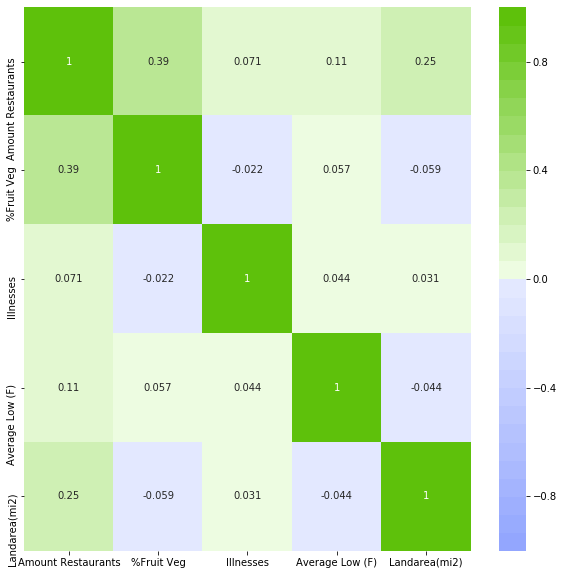

In [389]:
#a heatmap
plt.figure(figsize = (10,10))
sns.heatmap(plus_res_fruit_veg.corr(), cmap=sns.diverging_palette(-100, 120, s=99, l=70, sep=1, n=30), 
            annot=True, vmin=-1, vmax=1);

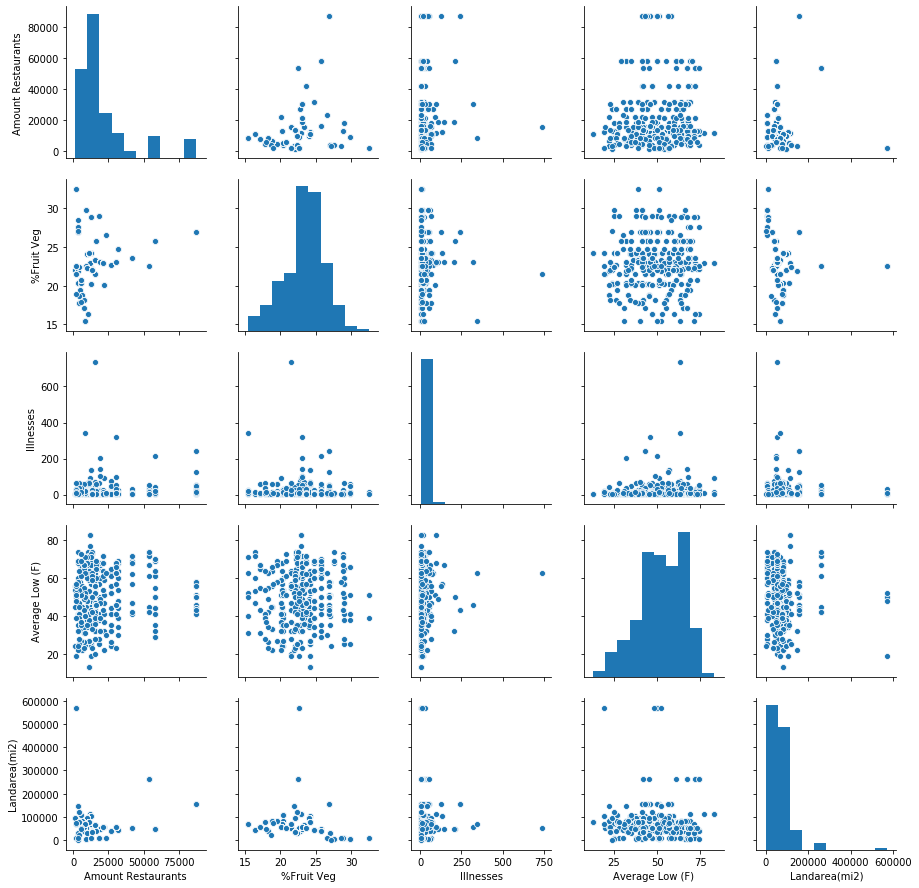

In [280]:
sns.pairplot(plus_res_fruit_veg)

#### Try including log illnesses as a term

In [282]:
rfg_log_ill = plus_res_fruit_veg.copy()
rfg_log_ill['log illnesses'] = np.log(rfg_log_ill['Illnesses'])

In [283]:
rfg_log_ill.corr()

,Amount Restaurants,%Fruit Veg,Illnesses,Average Low (F),Landarea(mi2),log illnesses
Amount Restaurants,1.000000,0.387672,0.070730,0.105281,0.249496,0.079724
%Fruit Veg,0.387672,1.000000,-0.021643,0.056631,-0.059360,-0.006466
Illnesses,0.070730,-0.021643,1.000000,0.043838,0.030959,0.631836
Average Low (F),0.105281,0.056631,0.043838,1.000000,-0.044242,0.086555
Landarea(mi2),0.249496,-0.059360,0.030959,-0.044242,1.000000,0.080159
log illnesses,0.079724,-0.006466,0.631836,0.086555,0.080159,1.000000


### Fit a base model to log illnesses

In [311]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('Train Score: ', train_score)
    print('Validation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [312]:
def adjusted_r_squared(X, y):
    adj_r2 = 1 - (1-lr.score(X,y))*(len(y)-1)/(len(y)-X.shape[1]-1)
    print(adj_r2)

In [325]:
def sv_lasso(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = Lasso(alpha=0.01)
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('Train Score: ', train_score)
    print('Validation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [313]:
lr = LinearRegression()
X = (rfg_log_ill.loc[:, ['Amount Restaurants', '%Fruit Veg', 
                         'Average Low (F)', 'Landarea(mi2)']])
y = rfg_log_ill.loc[:, 'log illnesses']

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.018111923591683232

In [314]:
adjusted_r_squared(X, y)

0.012818726414279946


In [315]:
split_and_validate(X, y)

Train Score:  0.010810922342831764
Validation R^2 score was: 0.042009752952948065
Feature coefficient results: 

Amount Restaurants : 0.00
%Fruit Veg : -0.01
Average Low (F) : 0.00
Landarea(mi2) : 0.00


#### Dummy the regions and strains

In [321]:
X2 = X.copy()
X2['Strain'] = rfg_log_ill['Strain']
X2['Region'] = rfg_log_ill['Region']
X2 = pd.get_dummies(X2)

# Fit the model
lr.fit(X2, y)

# Print out the R^2 for the model against the full dataset
lr.score(X2,y)

0.04742194459537019

In [322]:
adjusted_r_squared(X2, y)

0.01983002850778781


# SKIP HERE FOR BEST MODEL

In [323]:
split_and_validate(X2, y)

Train Score:  0.04458630266760766
Validation R^2 score was: 0.012657405196744409
Feature coefficient results: 

Amount Restaurants : 0.00
%Fruit Veg : 0.02
Average Low (F) : 0.00
Landarea(mi2) : 0.00
Strain_O103 : 0.02
Strain_O111 : 0.19
Strain_O111:NM : -0.52
Strain_O118:H16 : 0.00
Strain_O121 : 0.02
Strain_O146:H21 : 0.00
Strain_O157 : -0.37
Strain_O157:H7 : -0.14
Strain_O157:NM : 0.18
Strain_O26 : -0.13
Strain_O26:H11 : -0.66
Strain_O45:H2 : -0.22
Strain_O6:H16 : 1.63
Region_Midwest : 0.12
Region_Northeast : -0.30
Region_South : 0.16
Region_West : 0.02


#### Try Lasso on this model

In [326]:
sv_lasso(X2, y)

Train Score:  0.022707981680335942
Validation R^2 score was: 0.058762707922215274
Feature coefficient results: 

Amount Restaurants : 0.00
%Fruit Veg : 0.00
Average Low (F) : 0.00
Landarea(mi2) : 0.00
Strain_O103 : 0.00
Strain_O111 : 0.05
Strain_O111:NM : -0.00
Strain_O118:H16 : 0.00
Strain_O121 : 0.00
Strain_O146:H21 : 0.00
Strain_O157 : -0.04
Strain_O157:H7 : -0.03
Strain_O157:NM : 0.00
Strain_O26 : -0.00
Strain_O26:H11 : -0.00
Strain_O45:H2 : -0.00
Strain_O6:H16 : 0.00
Region_Midwest : 0.03
Region_Northeast : -0.22
Region_South : 0.03
Region_West : -0.00
